<a href="https://colab.research.google.com/github/mynxdy/D.D.D/blob/main/0806/%EB%94%A5%EB%9F%AC%EB%8B%9D_minyeong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Drowsiness Driving Detection 운전자 졸음 방지**

dataset
https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset

tistory
https://ys-cs17.tistory.com/24

### 0806



> test 돌려보기



In [ ]:
import os
import cv2

In [ ]:
def get_data(dir_path="/content/drive/MyDrive/22-1 숙탯2기딥러닝/train"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)       ### 변경1
                resized_array = cv2.resize(img_array, (34, 26))                         ### 변경2
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
data_train = get_data()

0
1


In [ ]:
X = []
y = []
for feature, label in data_train:
    X.append(feature)
    y.append(label)

In [ ]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
X.shape

(1452, 26, 34, 3)

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import torch.optim as optim

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
])

In [ ]:
from torch.utils.data import Dataset
import torch


class eyes_dataset(Dataset):
    def __init__(self, x_file_paths, y_file_path, transform=None):
        self.x_files = x_file_paths
        self.y_files = y_file_path
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x_files[idx]
        x = torch.from_numpy(x).float()   ##tensor로 변환하는거 아닌가..?

        y = self.y_files[idx]
        y = torch.from_numpy(y).float()

        return x, y

    def __len__(self):
        return len(self.x_files)

In [ ]:
train_dataset = eyes_dataset(X_train, y_train, transform=train_transform)    ###변경4

In [ ]:
type(y_train)    ##흠.. 넘파이 배열로 해야 작동이 됩니다. 텐서로 변환하면 넘파이로 변경하라는 오류가 나옵니다.

numpy.ndarray

In [ ]:
# X_train = torch.tensor(X_train)
# print(X_train.shape)

# y_train = torch.tensor(y_train)
# y_train.shape

# train_dataset = eyes_dataset(X_train, y_train, transform=train_transform)

model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)    ###input size 변경
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)


        return x

In [ ]:
PATH = '/content/drive/MyDrive/22-1 숙탯2기딥러닝/trained.pth'

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)

model = Net()
model.to('cuda')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [ ]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")
torch.save(model.state_dict(), PATH)

epoch: [1/50] train_loss: 0.43378 train_acc: 82.28750
epoch: [2/50] train_loss: 0.13136 train_acc: 96.05000
epoch: [3/50] train_loss: 0.08810 train_acc: 97.10000
epoch: [4/50] train_loss: 0.06947 train_acc: 97.58750
epoch: [5/50] train_loss: 0.05158 train_acc: 98.32500
epoch: [6/50] train_loss: 0.02962 train_acc: 99.40000
epoch: [7/50] train_loss: 0.03626 train_acc: 98.63750
epoch: [8/50] train_loss: 0.03079 train_acc: 99.25000
epoch: [9/50] train_loss: 0.01778 train_acc: 99.40000
epoch: [10/50] train_loss: 0.00542 train_acc: 100.00000
epoch: [11/50] train_loss: 0.00572 train_acc: 100.00000
epoch: [12/50] train_loss: 0.00304 train_acc: 100.00000
epoch: [13/50] train_loss: 0.00159 train_acc: 100.00000
epoch: [14/50] train_loss: 0.00261 train_acc: 100.00000
epoch: [15/50] train_loss: 0.00118 train_acc: 100.00000
epoch: [16/50] train_loss: 0.00100 train_acc: 100.00000
epoch: [17/50] train_loss: 0.00083 train_acc: 100.00000
epoch: [18/50] train_loss: 0.00053 train_acc: 100.00000
epoch: [19

test

In [ ]:
PATH = '/content/drive/MyDrive/22-1 숙탯2기딥러닝/trained.pth'

test_transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = eyes_dataset(X_test, y_test, transform=test_transform)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

model = Net()
model.to('cuda')
model.load_state_dict(torch.load(PATH))
model.eval()

count = 0

In [ ]:
with torch.no_grad():
    total_acc = 0.0
    acc = 0.0
    for i, test_data in enumerate(test_dataloader, 0):
        data, labels = test_data[0].to('cuda'), test_data[1].to('cuda')

        data = data.transpose(1, 3).transpose(2, 3)

        outputs = model(data)

        acc = accuracy(outputs, labels)
        total_acc += acc

        count = i

    print('avarage acc: %.5f' % (total_acc/count),'%')

print('test finish!')

avarage acc: 98.85057 %
test finish!


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


### 0723

이미지 불러와서 저장할 공간 생성

이미지 전처리

모델 공부

In [ ]:
#가보자고

In [ ]:
import numpy as np
import pandas as pd

import os
import cv2

from PIL import Image
from IPython.display import Image
import torch
import PIL


labels

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [ ]:
labels = os.listdir("/content/drive/MyDrive/22-1 숙탯2기딥러닝/train")   #os.listdir은 파일 경로없이 디렉토리의 모든 파일을 나열
labels = labels 
labels              

['no_yawn', 'yawn', 'Open', 'Closed']

visualize random 1 image

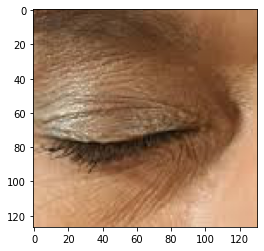

In [ ]:
import matplotlib.pyplot as plt

#closedEye
plt.imshow(plt.imread("/content/drive/MyDrive/22-1 숙탯2기딥러닝/train/Closed/_10.jpg"))

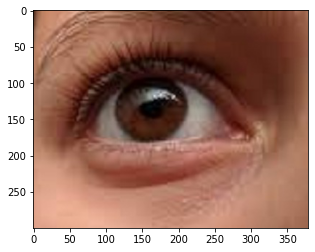

In [ ]:
#openEye
plt.imshow(plt.imread("/content/drive/MyDrive/22-1 숙탯2기딥러닝/train/Open/_100.jpg"))

image array & image shape

In [ ]:
a = plt.imread("/content/drive/MyDrive/22-1 숙탯2기딥러닝/train/Closed/_10.jpg")
a.shape                                                                          #결과는 (127,131,3)으로 가로 127,세로131,컬러이기 때문에 3이 나왔습니다.

(127, 131, 3)

for closed and open eye

In [ ]:
#컬러로 읽어온 이미지의 크기를 재정의하여 인덱스와 함께 리스트에 저장하는 함수

def get_data(dir_path="/content/drive/MyDrive/22-1 숙탯2기딥러닝/train/"):

    labels = ['Closed', 'Open']
    IMG_SIZE = 145    
    data = []         #이미지와 인덱스를 넣을 공간


    for label in labels:
        path = os.path.join(dir_path, label)      #path는 /content/drive/MyDrive/22-1 숙탯2기딥러닝/train/Closed(Open)이 됩니다.
        class_num = labels.index(label)           #Closed의 인덱스는 0, Open의 인덱스는 1입니다.
        #class_num +=2                            #각각의 인덱스에 2를 더해준 것은 이전에 하품을 하거나 하지 않은 경우의 인덱스가 0,1이기 때문입니다.
        print(class_num)      #인덱스 출력

        for img in os.listdir(path):              #Closed와 Open 안의 이미지 파일 이름을 의미합니다.
           
            #이걸 실행하고
            try:                        
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  #이미지 파일을 컬러로 읽은 다음 변수에 저장
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))        #읽어들인 이미지의 크기를 (145,145)로 변경
                data.append([resized_array, class_num])                            #데이터를 저장할 공간에 사이즈를 바꾼 이미지와 인덱스를 저장

            #오류가 나면 이걸 실행해라
            except Exception as e:      
                print(e)

    return data

data_train = get_data()                   #Closed의 인덱스 : 0, Open의 인덱스 : 1

0
1


separate label and features

In [ ]:
X = []          #독립변수; 모델링에 넣어야 할 feature 값
y = []          #종속변수; 눈을 떴는지, 감았는지에 대한 label을 넣어야겠군
for feature, label in data_train:
    X.append(feature)
    y.append(label)

In [ ]:
X = np.array(X)   #이미지 데이터 처리를 위해 클래스 객체를 Numpy배열로 변환합니다.
X.shape           #(총 이미지 개수, 가로, 세로, 컬러)

(1452, 145, 145, 3)

reshape the array

In [ ]:
X = np.array(X)
#X = X.reshape(-1,145,145,3)    #3차원 배열을 1차원 배열로 변경하기 위해 첫 번째 인자에 -1을 넣어줍니다.

LabelBinarizer

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_bin = LabelBinarizer()    #이진 레이블로 변환시키는 라이브러리
y = label_bin.fit_transform(y)

label array

In [ ]:
y = np.array(y)     #array배열로 변환
                    #list에서는 shape을 확인할 수 없기 때문에 array로 변환

train test split

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

length of X

In [ ]:
len(X_test)

436

In [ ]:
len(X_train)

1016

length of y

In [ ]:
len(y_test)

436

In [ ]:
len(y_train)

1016

shape of X & y

In [ ]:
X_train.shape    #1016개의 데이터, width=145, height=145, channel=3

(1016, 145, 145, 3)

In [ ]:
y_train.shape    #1016개의 데이터, 각각 라벨링 되어잇음

(1016, 1)

grayscale

In [ ]:
#흑백처리?

### 0730
train 데이터 모델 돌려보기

#### tistory

data_loader

In [ ]:
from torch.utils.data import Dataset
import torch

class eyes_dataset(Dataset):
    def __init__(self, x_file_paths, y_file_path, transform=None):
        self.x_files = x_file_paths
        self.y_files = y_file_path
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x_files[idx]
        x = torch.from_numpy(x).float()

        y = self.y_files[idx]
        y = torch.from_numpy(y).float()

        return x, y

    def __len__(self):
        return len(self.x_files)

train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.optim as optim


#tensor로 변경
train_transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
])


train_dataset = eyes_dataset(X_train, y_train, transform=train_transform)

In [ ]:
X_train.shape

(1016, 145, 145, 3)

In [ ]:
y_train.shape

(1016, 1)

model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 1. Conv2d
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # 2. activation
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # 3. pool
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)


        return x

In [ ]:
# trained parameter를 저장할 PATH
PATH = '/content/drive/MyDrive/22-1 숙탯2기딥러닝/train/'

#train_dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

model = Net()
model.to('cuda')  #GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [ ]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")
torch.save(model.state_dict(), PATH)

ValueError: ignored

grayscale

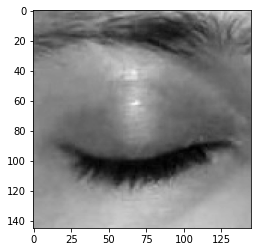

In [ ]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np


img_array = cv2.imread("/content/drive/MyDrive/22-1 숙탯2기딥러닝/train/Closed/_0.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_array,cmap="gray")

In [ ]:
img_array.shape

(145, 145)

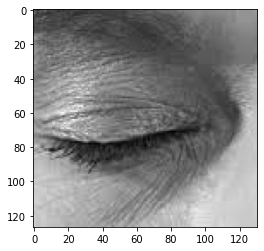

In [ ]:
Datadirectory = "/content/drive/MyDrive/22-1 숙탯2기딥러닝/train"
Classes = ["Closed","Open"]
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

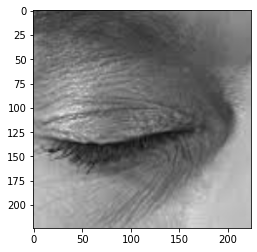

In [ ]:
img_size = 224
new_array= cv2.resize(backtorgb, (img_size,img_size))
plt.imshow(new_array, cmap="gray")
plt.show()

In [ ]:
img_array.shape

(127, 131)

In [ ]:
training_Data = []

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
                new_array = cv2.resize(backtorgb, (img_size,img_size))
                training_Data.append([new_array,class_num])
            except Exception as e:
                pass

In [ ]:
create_training_Data()

In [ ]:
print(len(training_Data))

1452


In [ ]:
X=[]
y=[]

for features,label in training_Data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1,img_size, img_size,3)

In [ ]:
X.shape

(1452, 224, 224, 3)

In [ ]:
X=X/255.0;

In [ ]:
Y= np.array(y)

In [ ]:
X.shape

(1452, 224, 224, 3)

#### kaggle

Libraries

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Data Augmentation(데이터 증식)
- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 데이터로부터 그럴듯한 이미지를 랜덤하게 생성하여 데이터의 수를 늘린다.
  - zoom_range: 확대 비율([lower,upper]=[1-zoom_range,1+zoom_range])
  - horizontal_flip: 수평으로 뒤집음(mirror image)
  - rotation_range: random rotation 각도 범위(0-180)

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
train_generator

model

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
32/32 [==============================] - 19s 245ms/step - loss: 1072.4973 - accuracy: 0.1870 - val_loss: 4235.4663 - val_accuracy: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 6s 188ms/step - loss: 83797.0469 - accuracy: 0.2175 - val_loss: 137857.8594 - val_accuracy: 0.0138
Epoch 3/50
32/32 [==============================] - 6s 186ms/step - loss: 1521151.6250 - accuracy: 0.2451 - val_loss: 3375085.5000 - val_accuracy: 0.9885
Epoch 4/50
32/32 [==============================] - 6s 187ms/step - loss: 15029913.0000 - accuracy: 0.2766 - val_loss: 39424156.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
32/32 [==============================] - 6s 185ms/step - loss: 68014728.0000 - accuracy: 0.2106 - val_loss: 217365088.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
32/32 [==============================] - 6s 184ms/step - loss: 366345600.0000 - accuracy: 0.2372 - val_loss: 292935776.0000 - val_accuracy: 0.0000e+00
Epoch 7/50
32/32 [==============================] - 6s 186m

hitory

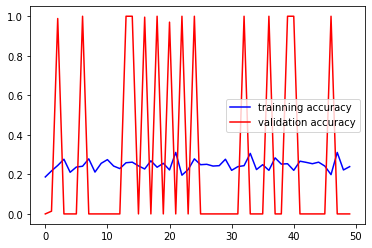

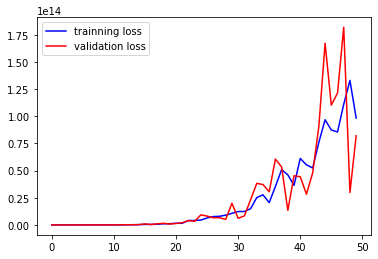

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

###0803

####Tistory로 크기 통일 및 GRAYSCALE

In [ ]:
import os
import cv2

In [ ]:
def get_data(dir_path="/content/drive/MyDrive/22-1 숙탯2기딥러닝/train"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   ### 변경1
                resized_array = cv2.resize(img_array, (34, 26))                         ### 변경2
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
data_train = get_data()

0
1


In [ ]:
X = []
y = []
for feature, label in data_train:
    X.append(feature)
    y.append(label)

In [ ]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
X = X.reshape(1452, 26, 34,1)    ### 변경3

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import torch.optim as optim

In [ ]:
# train_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomRotation(10),
#     transforms.RandomHorizontalFlip(),
# ])

In [ ]:
from torch.utils.data import Dataset
import torch


class eyes_dataset(Dataset):
    def __init__(self, x_file_paths, y_file_path, transform=None):
        self.x_files = x_file_paths
        self.y_files = y_file_path
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x_files[idx]
        x = torch.from_numpy(x).float()   ##tensor로 변환하는거 아닌가..?

        y = self.y_files[idx]
        y = torch.from_numpy(y).float()

        return x, y

    def __len__(self):
        return len(self.x_files)

In [ ]:
train_dataset = eyes_dataset(X_train, y_train)    ###변경4

In [ ]:
type(y_train)    ##흠.. 넘파이 배열로 해야 작동이 됩니다. 텐서로 변환하면 넘파이로 변경하라는 오류가 나옵니다.

numpy.ndarray

In [ ]:
# X_train = torch.tensor(X_train)
# print(X_train.shape)

# y_train = torch.tensor(y_train)
# y_train.shape

# train_dataset = eyes_dataset(X_train, y_train, transform=train_transform)

model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)


        return x

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)

In [ ]:
model = Net()
model.to('cuda')

#os.environ["CUDA_VISIBLE_DEVICES"]

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [ ]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")      ##하드웨어에 맞게 batch size를 변경해야 결과가 나옵니다. 저는 8로 설정했습니다.

epoch: [1/50] train_loss: 0.40663 train_acc: 84.48750
epoch: [2/50] train_loss: 0.15447 train_acc: 95.13750
epoch: [3/50] train_loss: 0.11570 train_acc: 95.87500
epoch: [4/50] train_loss: 0.08453 train_acc: 96.65000
epoch: [5/50] train_loss: 0.03493 train_acc: 99.10000
epoch: [6/50] train_loss: 0.05166 train_acc: 97.86250
epoch: [7/50] train_loss: 0.01735 train_acc: 99.70000
epoch: [8/50] train_loss: 0.02417 train_acc: 99.23750
epoch: [9/50] train_loss: 0.01051 train_acc: 99.70000
epoch: [10/50] train_loss: 0.00713 train_acc: 100.00000
epoch: [11/50] train_loss: 0.00376 train_acc: 100.00000
epoch: [12/50] train_loss: 0.00290 train_acc: 100.00000
epoch: [13/50] train_loss: 0.00205 train_acc: 100.00000
epoch: [14/50] train_loss: 0.00194 train_acc: 100.00000
epoch: [15/50] train_loss: 0.00112 train_acc: 100.00000
epoch: [16/50] train_loss: 0.00111 train_acc: 100.00000
epoch: [17/50] train_loss: 0.00100 train_acc: 100.00000
epoch: [18/50] train_loss: 0.00121 train_acc: 100.00000
epoch: [19

In [ ]:
# plt.style.use('dark_background')
# fig = plt.figure()

# for i in range(len(train_dataset)):
#     x, y = train_dataset[i]

#     plt.subplot(2, 1, 1)
#     plt.title(str(y_train[i]))
#     plt.imshow(X_train[i].reshape((26, 34)), cmap='gray')

#     plt.show()

test

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = eyes_dataset(X_test, y_test, transform=test_transform)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

model = Net()
model.to('cuda')
model.eval()

count = 0

In [ ]:
with torch.no_grad():
    total_acc = 0.0
    acc = 0.0
    for i, test_data in enumerate(test_dataloader, 0):
        data, labels = test_data[0].to('cuda'), test_data[1].to('cuda')

        data = data.transpose(1, 3).transpose(2, 3)

        outputs = model(data)

        acc = accuracy(outputs, labels)
        total_acc += acc

        count = i

    print('avarage acc: %.5f' % (total_acc/count),'%')

print('test finish!')

avarage acc: 51.26437 %
test finish!


#### Tistory 크기 통일 및 GRAYSCALE + 텐서로 돌려보기

In [ ]:
import os
import cv2

In [ ]:
def get_data(dir_path="/content/drive/MyDrive/22-1 숙탯2기딥러닝/train"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   ### 변경1
                resized_array = cv2.resize(img_array, (34, 26))                         ### 변경2
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
data_train = get_data()

0
1


In [ ]:
X = []
y = []
for feature, label in data_train:
    X.append(feature)
    y.append(label)

In [ ]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape

(1452, 26, 34)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
X = X.reshape(1452,1, 26, 34)    ### 변경3

In [ ]:
X.shape

(1452, 1, 26, 34)

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import torch.optim as optim

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
])

In [ ]:
from torch.utils.data import Dataset
import torch


class eyes_dataset(Dataset):
    def __init__(self, x_file_paths, y_file_path, transform=None):
        self.x_files = x_file_paths
        self.y_files = y_file_path
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x_files[idx]
        x = torch.from_numpy(np.asarray(x)).float()   ##np.asaray(x)로 변경

        y = self.y_files[idx]
        y = torch.from_numpy(np.asarray(y)).float()

        return x, y

    def __len__(self):
        return len(self.x_files)

In [ ]:
train_dataset = eyes_dataset(X_train, y_train, transform=train_transform) 

In [ ]:
type(y_train)    ##transform을 해줘도 넘파이 배열이 나옵니다.

numpy.ndarray

In [ ]:
X_train = torch.tensor(X_train)  ###텐서로 변경
print(X_train.shape)

y_train = torch.tensor(y_train)
print(y_train.shape)

train_dataset = eyes_dataset(X_train, y_train, transform=train_transform)

torch.Size([1016, 1, 26, 34])
torch.Size([1016, 1])


model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)


        return x

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)

In [ ]:
model = Net()
model.to('cuda')

#os.environ["CUDA_VISIBLE_DEVICES"]

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50

In [ ]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0

    model.train()

    for i, data in enumerate(train_dataloader, 0):
        input_1, labels = data[0].to('cuda'), data[1].to('cuda')

        input = input_1.transpose(1, 3).transpose(2, 3)

        optimizer.zero_grad()

        outputs = model(input)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

        if i % 80 == 79:
            print('epoch: [%d/%d] train_loss: %.5f train_acc: %.5f' % (
                epoch + 1, epochs, running_loss / 80, running_acc / 80))
            running_loss = 0.0

print("learning finish")      ##하드웨어에 맞게 batch size를 변경해야 결과가 나옵니다. 저는 8로 설정했습니다.

RuntimeError: ignored

test

### 0716


In [ ]:
##data_loader.py##
from torch.utils.data import Dataset
import torch


class eyes_dataset(Dataset):
    def __init__(self, x_file_paths, y_file_path, transform=None):
        self.x_files = x_file_paths
        self.y_files = y_file_path
        self.transform = transform

    def __getitem__(self, idx):
        x = self.x_files[idx]
        x = torch.from_numpy(x).float()

        y = self.y_files[idx]
        y = torch.from_numpy(y).float()  #GPU 연산을 위해 자료형을 tensor로 변환

        return x, y

    def __len__(self):
        return len(self.x_files)

#제가 찾은 예제에서 x_file과 y_file은 형식이 npy라는 확장자를 가진 이미지입니다.
#npy는 numpy 자료형으로 이미지를 저장합니다.

# x_file의 shape은 (2586,26,34,1) -> 2586개 데이터의 width=26, height=34, channel=1로 구성됩니다.
# y_file의 shape은 (2586, 1) -> 2586개의 데이터 각각에 라벨링이 있습니다.
  # 라벨링은 눈을 감으면 0, 뜨면 1로 구성됩니다.

In [ ]:
##model.py##

import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 1. Conv2d(input_channel_size, output_volume_size, kernel_size)
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # 흑백 1장, 채널 수는 32, 채널 크기는 3
        # 결과 : 32개의 필터(채널)은 32개의 특징맵 생성
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # covn2에서 64개의 필터(채널)은 각각 conv1에서 나온 32개의 특징맵을 보고 다시 1개의 특징맵을 생성 → 총 64개의 특징맵 생성
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # conv3도 마찬가지

        # 2. activation
        self.fc1 = nn.Linear(1536, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # 3. pool
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.reshape(-1, 1536)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)


        return x


# model은 binary classification / 눈을 감으면 0, 뜨면 1
# Conv, activation, pool의 3번의 과정을 거쳐 2번의 linear layer을 통해 최종적인 값이 나옴
# 이 최종적인 값으로 loss를 구하고, Probability를 구해 boundary를 0.5로 잡고 눈을 감았는지 떴는지 판단

# 컨브넷은 (image_height, image_width, image_channels) 크기의 입력 텐서 사용
    # 여기서는 input_shape=(26,34,1)임


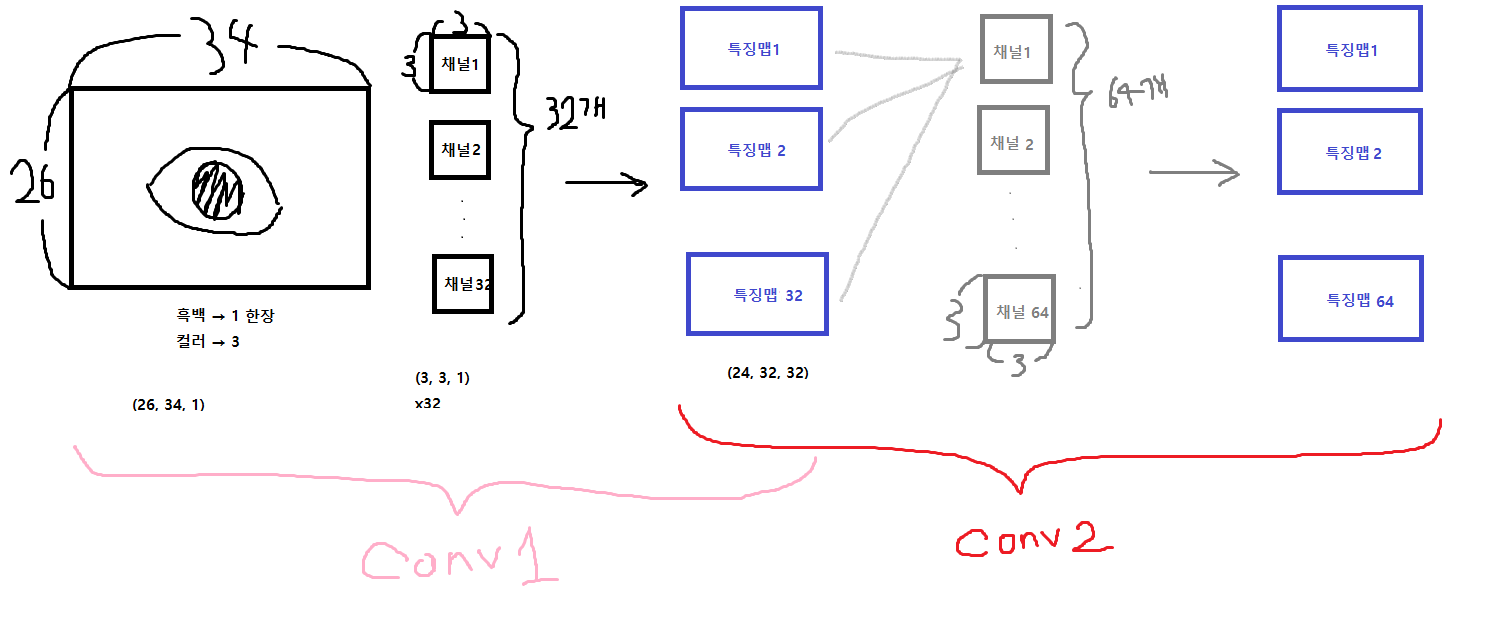

In [ ]:
model = Net().to('cuda')
summary(model, (1,26,34))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 34]             320
            Conv2d-2           [-1, 64, 13, 17]          18,496
            Conv2d-3            [-1, 128, 6, 8]          73,856
            Linear-4                  [-1, 512]         786,944
            Linear-5                    [-1, 1]             513
Total params: 880,129
Trainable params: 880,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 3.36
Estimated Total Size (MB): 3.74
----------------------------------------------------------------
